# Whole genome lifted over analysis at 25kb resolution
All windows that lifted over were used for CHESS analysis

### 1. Generating .bedpe file
#### Dividing the genomes into 500kb windows (250 kb step size) => x.bed

In [16]:
cat /scratch/ak8725/IR64_new/map_generation/IR64.genome

chr01	44350042
chr02	37111999
chr03	38826278
chr04	35281998
chr05	31013547
chr06	32151555
chr07	31201142
chr08	30180556
chr09	24266242
chr10	25557007
chr11	31218896
chr12	25539636


In [20]:
# Define window size and step size
window_size = 500000  # 500 kb
step_size = 250000    # 250 kb

# Read genome sizes from file
genome_sizes = {}
with open('/scratch/ak8725/omer_mrg/map_generation/omer.genome', 'r') as genome_file:
    for line in genome_file:
        chromosome, size = line.strip().split('\t')
        genome_sizes[chromosome] = int(size)

# Generate BED coordinates
bed_coordinates = []
for chromosome, size in genome_sizes.items():
    for window_start in range(0, size - window_size + 1, step_size):
        window_end = window_start + window_size
        bed_coordinates.append((chromosome, window_start, window_end))

# Write coordinates to BED file
with open('omer.bed', 'w') as bed_file:
    for chromosome, start, end in bed_coordinates:
        bed_file.write(f'{chromosome}\t{start}\t{end}\n')

In [304]:
#lifting over coordinates from az to oruf
!/share/apps/kent/385/liftOver -ends=1 oruf.bed  ../../liftOver/chain_files_chess/oruf_omer.over.chain oruf-omer.bed unMapped

Reading liftover chains
Mapping coordinates


Out of 1499 intervals, 1044 are converted which is 1044/1499 = 30.35%

In [305]:
#deleting windows from NPB that were not lifted over to Az
# Read the unMapped_starts file and store the coordinates to remove
coordinates_to_remove = set()
with open("unMapped", "r") as unMapped_file:
    for line in unMapped_file:
        if not line.startswith("#"):
            chromosome, start, end = line.strip().split("\t")
            coordinates_to_remove.add((chromosome, start, end))

# Read the NPB-Az.bed file and write the filtered coordinates to a new file
with open("oruf.bed", "r") as bed_file, open("oruf-omer_filtered.bed", "w") as filtered_file:
    for line in bed_file:
        chromosome, start, end = line.strip().split()
        if (chromosome, start, end) not in coordinates_to_remove:
            filtered_file.write(f"{chromosome}\t{start}\t{end}\n")

In [306]:
!wc -l oruf.bed #number of windows in az
!wc -l oruf-omer.bed #number of windows that were lifted over to Azucena, should be equal to:
!wc -l oruf-omer_filtered.bed #number of windows in NPB after filtering out those that were not lifted over
!wc -l unMapped #windows not lifted over (divide by 2)

1333 oruf.bed
346 oruf-omer.bed
346 oruf-omer_filtered.bed
1974 unMapped


In [307]:
#Generating .bedpe files for CHESS
#stored in /bedpe
#col1,2,3 - coordinates in oruf
#col4,5,6 - coordinates in omer
with open("oruf-omer_filtered.bed", "r") as filtered_file, \
     open("oruf-omer.bed", "r") as conv_file, \
     open("oruf-omer_pairs.bedpe", "w") as pairs_file:
    for row_num, (filtered_line, conv_line) in enumerate(zip(filtered_file, conv_file), start=1):
        filtered_parts = filtered_line.strip().split("\t")
        conv_parts = conv_line.strip().split("\t")
        
        if len(filtered_parts) >= 3 and len(conv_parts) >= 3:
            col1, col2, col3 = filtered_parts
            col4, col5, col6 = conv_parts[:3]
            
            pairs_file.write(f"{col1}\t{col2}\t{col3}\t{col4}\t{col5}\t{col6}\t{row_num}\t.\t+\t+\n")

### 3. Running chess-sim.sh at 25kb without background comparisons (--background query=FALSE)
Took 1:10:00 for all 6 pairs

### 4. Generate random pairs

In [3]:
import os
import pandas as pd
from pathlib import Path 

original_pair_file_path = '/scratch/ak8725/chess/whole_lifted/bedpe/omer-omer_pairs.bedpe'
random_pair_files_folder_path = '/scratch/ak8725/chess/whole_lifted/omer-omer/random_pairs'

df = pd.read_csv(original_pair_file_path, sep='\t', header=None)
for index in range(1, 101):
  df_permute = pd.DataFrame({0:df[3], 1:df[4], 2:df[5]})
  df_permute = df_permute.sample(frac = 1)
  df_permute.reset_index(inplace=True)

  df_random = pd.DataFrame({'chromosomes1': df[0],
                          'region_start1': df[1],
                          'region_end1': df[2],
                          'chromosomes2': df_permute[0],
                          'random_start2': df_permute[1],
                          'random_end2': df_permute[2],
                          'pair_id': df[6],
                          'dot': df[7],
                          'strand1': df[8],
                          'strand2': df[9]})

  df_random.to_csv(f'{random_pair_files_folder_path}/{Path(original_pair_file_path).stem}_random_gen_{index}.bedpe', sep='\t', index=False, header=False)

4. Running chess-sim-random.sh<br/>
Took from 16 to >24 hrs per run

### 5. Plotting all the results

### Nipponbare biological replicates

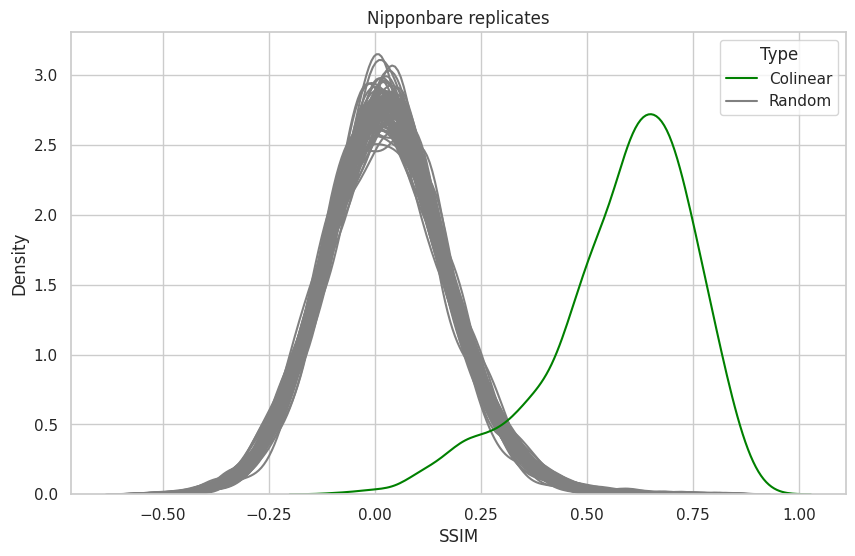

Total number of ssim values: 1221
Number of rows with SN >= 0.5': 1196
Mode of the density plot: 0.65
Average Mode of the density plots for random pairs': -0.043903812887101934
Normalized mode of the SSIM values: 0.693903812887102


In [14]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_folder_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions_NPB_ref/NPB-NPB/random_results_25'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'NPB-NPB_chess_whole_25kb.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# def custom_filter(row):
#     if row['type'] == 'experiment':
#         return row['p_bg'] <= 0.05
#     return True

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()

final_df_filtered['plot_order'] = final_df_filtered['type'].apply(lambda x: 0 if x == 'experiment' else 1)
final_df_filtered = final_df_filtered.sort_values(by='plot_order')

palette = {key: 'green' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)
handles, labels = plot.get_legend_handles_labels()

custom_handles = [plt.Line2D([0], [0], color='green'), plt.Line2D([0], [0], color='gray')]
custom_labels = ['Colinear', 'Random']

plt.legend(custom_handles, custom_labels, title='Type')

plt.xlabel('SSIM')
plt.ylabel('Density')
plt.title('Nipponbare replicates')

# Save the plot to a new PNG file with higher resolution (300 dpi)
output_file_path = '/scratch/ak8725/figs/figS6-1.pdf'
plt.savefig(output_file_path)

plt.show()

# Count rows with type 'experiment'
rows_count = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", rows_count)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5':", experiment_rows_count)

#calculate mode of experiment
import numpy as np
import scipy.stats as stats

random_modes = []
experiment_mode = None

for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value
formatted_mode = f"{experiment_mode:.2f}"

# Print the mode for 'experiment'
print(f"Mode of the density plot: {formatted_mode}")

import numpy as np
import scipy.stats as stats
import pandas as pd

# Assuming 'final_df_filtered' is your DataFrame

# Create a list to collect mode values for random_{index}
random_modes = []

# Variables to store mode for 'experiment'
experiment_mode = None

# Find mode for each density plot
for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['z_ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value

# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for random pairs': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

formatted_mode_numeric = float(formatted_mode)  # Convert to float if it's a string
result = formatted_mode_numeric - average_random_mode
print(f'Normalized mode of the SSIM values: {result}')

### Azucena biological replicates

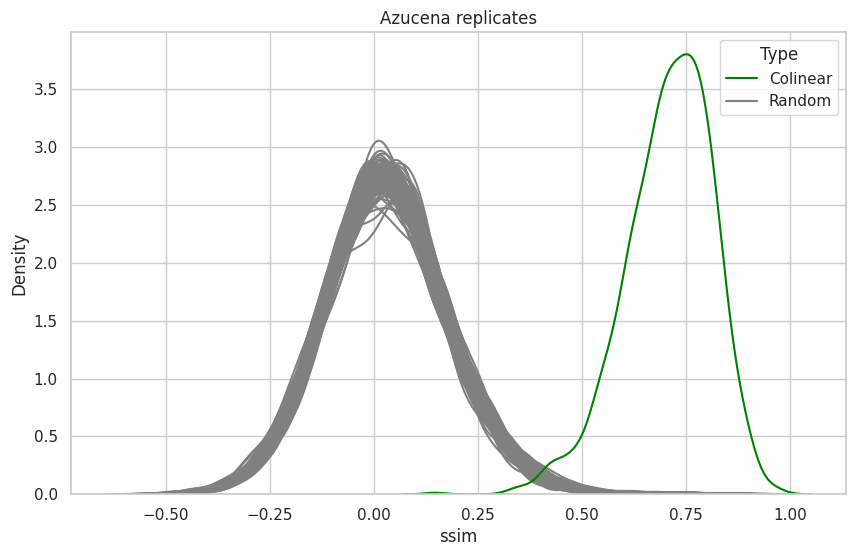

Total number of ssim values: 1221
Number of rows with SN >= 0.5': 1193
Mode of the density plot: 0.75
Average Mode of the density plots for random pairs': 0.024174802349040885
Normalized mode of the SSIM values: 0.7258251976509591


In [13]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_folder_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions_NPB_ref/Az-Az/results_25'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'Az-Az_chess_whole_25kb.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# def custom_filter(row):
#     if row['type'] == 'experiment':
#         return row['p_bg'] <= 0.05
#     return True

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()

final_df_filtered['plot_order'] = final_df_filtered['type'].apply(lambda x: 0 if x == 'experiment' else 1)
final_df_filtered = final_df_filtered.sort_values(by='plot_order')

palette = {key: 'green' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)
handles, labels = plot.get_legend_handles_labels()

custom_handles = [plt.Line2D([0], [0], color='green'), plt.Line2D([0], [0], color='gray')]
custom_labels = ['Colinear', 'Random']

plt.legend(custom_handles, custom_labels, title='Type')

plt.xlabel('ssim')
plt.ylabel('Density')
plt.title('Azucena replicates')

# Save the plot to a new PNG file with higher resolution (300 dpi)
output_file_path = '/scratch/ak8725/figs/figS6-2.pdf'
plt.savefig(output_file_path)

plt.show()

# Count rows with type 'experiment'
rows_count = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", rows_count)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5':", experiment_rows_count)

#calculate mode of experiment
import numpy as np
import scipy.stats as stats

random_modes = []
experiment_mode = None

for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value
formatted_mode = f"{experiment_mode:.2f}"

# Print the mode for 'experiment'
print(f"Mode of the density plot: {formatted_mode}")

# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for random pairs': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

formatted_mode_numeric = float(formatted_mode)  # Convert to float if it's a string
result = formatted_mode_numeric - average_random_mode
print(f'Normalized mode of the SSIM values: {result}')

### IR64 biological replicates

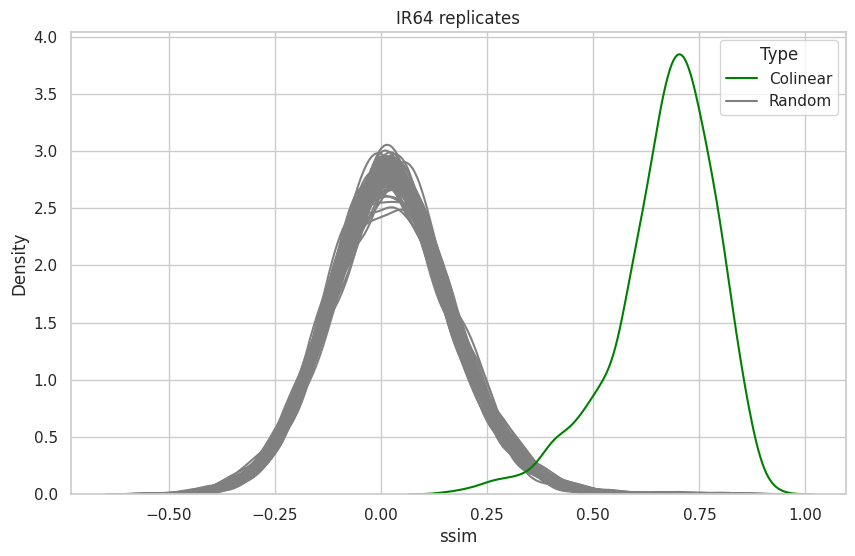

Total number of ssim values: 1530
Number of rows with SN >= 0.5': 1510
Mode of the density plot: 0.70
Average Mode of the density plots for random pairs': 0.016253787271662715
Normalized mode of the SSIM values: 0.6837462127283372


In [15]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_folder_path = '/scratch/ak8725/chess/whole_lifted/ir64-ir64/random_results'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'ir64-ir64.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# def custom_filter(row):
#     if row['type'] == 'experiment':
#         return row['p_bg'] <= 0.05
#     return True

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()

final_df_filtered['plot_order'] = final_df_filtered['type'].apply(lambda x: 0 if x == 'experiment' else 1)
final_df_filtered = final_df_filtered.sort_values(by='plot_order')

palette = {key: 'green' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)
handles, labels = plot.get_legend_handles_labels()

custom_handles = [plt.Line2D([0], [0], color='green'), plt.Line2D([0], [0], color='gray')]
custom_labels = ['Colinear', 'Random']

plt.legend(custom_handles, custom_labels, title='Type')

plt.xlabel('ssim')
plt.ylabel('Density')
plt.title('IR64 replicates')

# Save the plot to a new PNG file with higher resolution (300 dpi)
output_file_path = '/scratch/ak8725/figs/figS6-3.pdf'
plt.savefig(output_file_path)

plt.show()

# Count rows with type 'experiment'
rows_count = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", rows_count)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5':", experiment_rows_count)

#calculate mode of experiment
import numpy as np
import scipy.stats as stats

random_modes = []
experiment_mode = None

for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value
formatted_mode = f"{experiment_mode:.2f}"

# Print the mode for 'experiment'
print(f"Mode of the density plot: {formatted_mode}")
# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for random pairs': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

formatted_mode_numeric = float(formatted_mode)  # Convert to float if it's a string
result = formatted_mode_numeric - average_random_mode
print(f'Normalized mode of the SSIM values: {result}')

### Oruf biological replicates

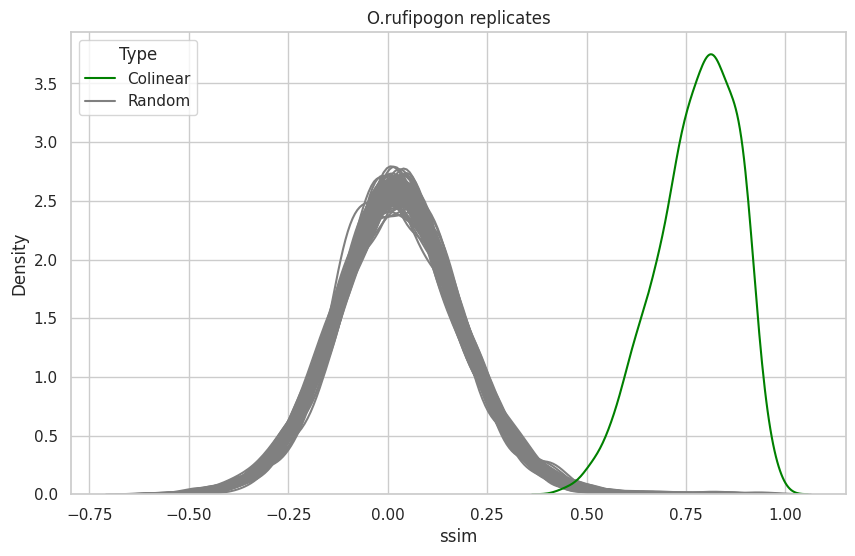

Total number of ssim values: 1333
Number of rows with SN >= 0.5': 1320
Mode of the density plot: 0.81
Average Mode of the density plots for random pairs': 0.02064451895181981
Normalized mode of the SSIM values: 0.7893554810481802


In [16]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_folder_path = '/scratch/ak8725/chess/whole_lifted/oruf-oruf/random_results'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'oruf-oruf.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# def custom_filter(row):
#     if row['type'] == 'experiment':
#         return row['p_bg'] <= 0.05
#     return True

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()

final_df_filtered['plot_order'] = final_df_filtered['type'].apply(lambda x: 0 if x == 'experiment' else 1)
final_df_filtered = final_df_filtered.sort_values(by='plot_order')

palette = {key: 'green' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)
handles, labels = plot.get_legend_handles_labels()

custom_handles = [plt.Line2D([0], [0], color='green'), plt.Line2D([0], [0], color='gray')]
custom_labels = ['Colinear', 'Random']

plt.legend(custom_handles, custom_labels, title='Type')

plt.xlabel('ssim')
plt.ylabel('Density')
plt.title('O.rufipogon replicates')

# Save the plot to a new PNG file with higher resolution (300 dpi)
output_file_path = '/scratch/ak8725/figs/figS6-4.pdf'
plt.savefig(output_file_path)

plt.show()

# Count rows with type 'experiment'
rows_count = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", rows_count)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5':", experiment_rows_count)

#calculate mode of experiment
import numpy as np
import scipy.stats as stats

random_modes = []
experiment_mode = None

for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value
formatted_mode = f"{experiment_mode:.2f}"

# Print the mode for 'experiment'
print(f"Mode of the density plot: {formatted_mode}")

# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for random pairs': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

formatted_mode_numeric = float(formatted_mode)  # Convert to float if it's a string
result = formatted_mode_numeric - average_random_mode
print(f'Normalized mode of the SSIM values: {result}')

### Omer biological replicates

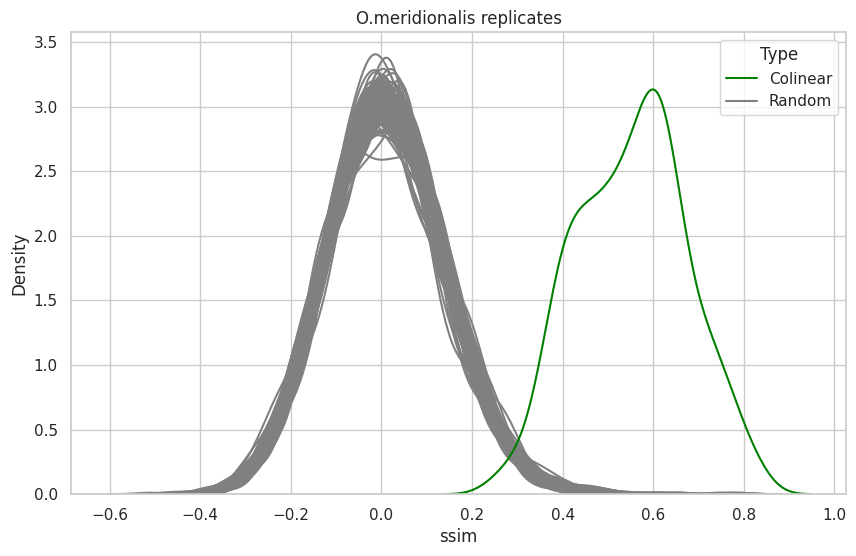

Total number of ssim values: 1502
Number of rows with SN >= 0.5': 267
Mode of the density plot: 0.60
Average Mode of the density plots for random pairs': 0.004454003187603133
Normalized mode of the SSIM values: 0.5955459968123968


In [17]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_folder_path = '/scratch/ak8725/chess/whole_lifted/omer-omer/random_results'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'omer-omer.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# def custom_filter(row):
#     if row['type'] == 'experiment':
#         return row['p_bg'] <= 0.05
#     return True

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.7)].copy()

final_df_filtered['plot_order'] = final_df_filtered['type'].apply(lambda x: 0 if x == 'experiment' else 1)
final_df_filtered = final_df_filtered.sort_values(by='plot_order')

palette = {key: 'green' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)
handles, labels = plot.get_legend_handles_labels()

custom_handles = [plt.Line2D([0], [0], color='green'), plt.Line2D([0], [0], color='gray')]
custom_labels = ['Colinear', 'Random']

plt.legend(custom_handles, custom_labels, title='Type')

plt.xlabel('ssim')
plt.ylabel('Density')
plt.title('O.meridionalis replicates')

# Save the plot to a new PNG file with higher resolution (300 dpi)
output_file_path = '/scratch/ak8725/figs/figS6-5.pdf'
plt.savefig(output_file_path)

plt.show()

# Count rows with type 'experiment'
rows_count = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", rows_count)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5':", experiment_rows_count)

#calculate mode of experiment
import numpy as np
import scipy.stats as stats

random_modes = []
experiment_mode = None

for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value
formatted_mode = f"{experiment_mode:.2f}"

# Print the mode for 'experiment'
print(f"Mode of the density plot: {formatted_mode}")

# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for random pairs': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

formatted_mode_numeric = float(formatted_mode)  # Convert to float if it's a string
result = formatted_mode_numeric - average_random_mode
print(f'Normalized mode of the SSIM values: {result}')

### Nipponbare - Azucena

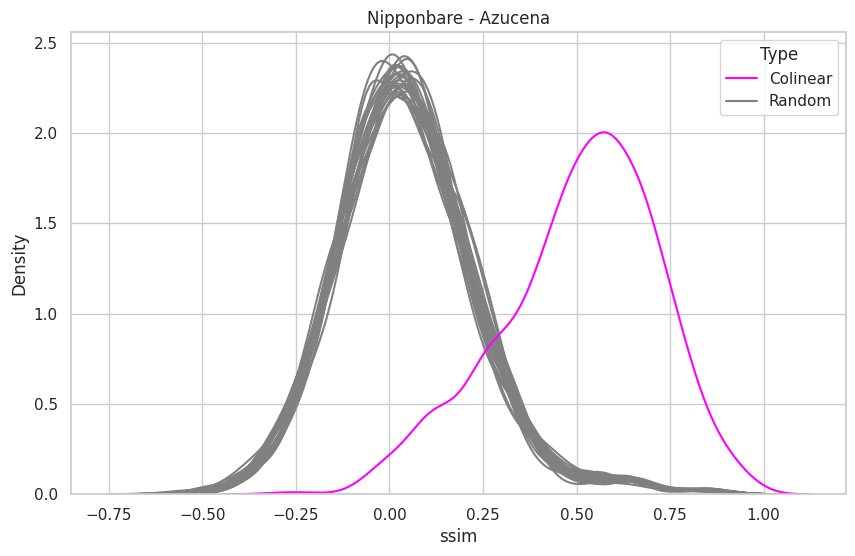

Total number of ssim values: 1221
Number of rows with SN >= 0.5': 1121
Mode of the density plot: 0.57
Average Mode of the density plots for random pairs': 0.02201533555943434
Normalized mode of the SSIM values: 0.5479846644405656


In [2]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_folder_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions_NPB_ref/NPB-Az/results_npb_az-25'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'NPB-Az_chess_whole_25kb.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# def custom_filter(row):
#     if row['type'] == 'experiment':
#         return row['p_bg'] <= 0.05
#     return True

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()

final_df_filtered['plot_order'] = final_df_filtered['type'].apply(lambda x: 0 if x == 'experiment' else 1)
final_df_filtered = final_df_filtered.sort_values(by='plot_order')

palette = {key: 'magenta' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)
handles, labels = plot.get_legend_handles_labels()

custom_handles = [plt.Line2D([0], [0], color='magenta'), plt.Line2D([0], [0], color='gray')]
custom_labels = ['Colinear', 'Random']

plt.legend(custom_handles, custom_labels, title='Type')

plt.xlabel('ssim')
plt.ylabel('Density')
plt.title('Nipponbare - Azucena')

# Save the plot to a new PNG file with higher resolution (300 dpi)
plt.savefig('/scratch/ak8725/figs/fig6/fig6A-1.pdf')

plt.show()

# Count rows with type 'experiment'
rows_count = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", rows_count)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5':", experiment_rows_count)

#calculate mode of experiment
import numpy as np
import scipy.stats as stats

random_modes = []
experiment_mode = None

for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value
formatted_mode = f"{experiment_mode:.2f}"

# Print the mode for 'experiment'
print(f"Mode of the density plot: {formatted_mode}")
# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for random pairs': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

formatted_mode_numeric = float(formatted_mode)  # Convert to float if it's a string
result = formatted_mode_numeric - average_random_mode
print(f'Normalized mode of the SSIM values: {result}')

### Nipponbare - IR64

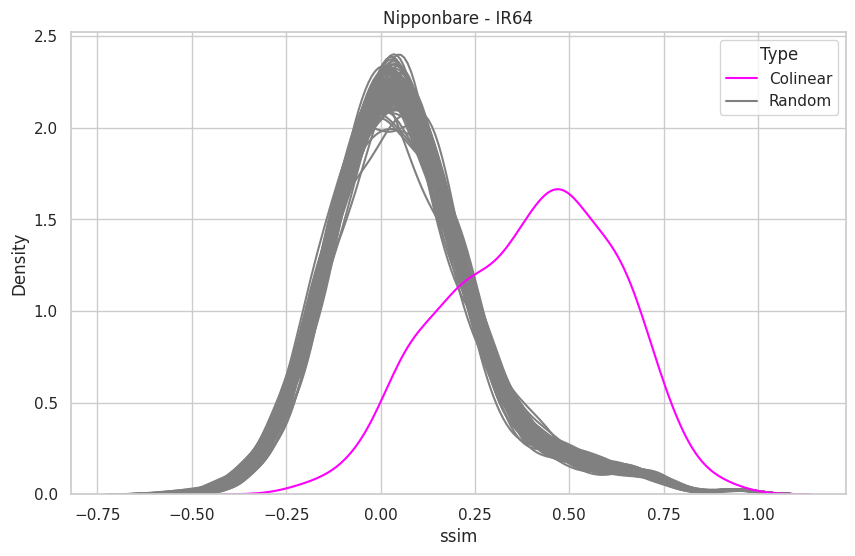

Total number of ssim values: 982
Number of rows with SN >= 0.5': 828
Mode of the density plot: 0.47
Average Mode of the density plots for random pairs': 0.02994410536978595
Normalized mode of the SSIM values: 0.440055894630214


In [3]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_folder_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions_NPB_ref/NPB-IR64/random_results_25'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'NPB-IR64_chess_results_25kb.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# def custom_filter(row):
#     if row['type'] == 'experiment':
#         return row['p_bg'] <= 0.05
#     return True

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()

final_df_filtered['plot_order'] = final_df_filtered['type'].apply(lambda x: 0 if x == 'experiment' else 1)
final_df_filtered = final_df_filtered.sort_values(by='plot_order')

palette = {key: 'magenta' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)
handles, labels = plot.get_legend_handles_labels()

custom_handles = [plt.Line2D([0], [0], color='magenta'), plt.Line2D([0], [0], color='gray')]
custom_labels = ['Colinear', 'Random']

plt.legend(custom_handles, custom_labels, title='Type')

plt.xlabel('ssim')
plt.ylabel('Density')
plt.title('Nipponbare - IR64')

# Save the plot to a new PNG file with higher resolution (300 dpi)
plt.savefig('/scratch/ak8725/figs/fig6/fig6A-2.pdf')

plt.show()

# Count rows with type 'experiment'
rows_count = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", rows_count)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5':", experiment_rows_count)

#calculate mode of experiment
import numpy as np
import scipy.stats as stats

random_modes = []
experiment_mode = None

for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value
formatted_mode = f"{experiment_mode:.2f}"

# Print the mode for 'experiment'
print(f"Mode of the density plot: {formatted_mode}")
# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for random pairs': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

formatted_mode_numeric = float(formatted_mode)  # Convert to float if it's a string
result = formatted_mode_numeric - average_random_mode
print(f'Normalized mode of the SSIM values: {result}')

### Nipponbare - Oruf

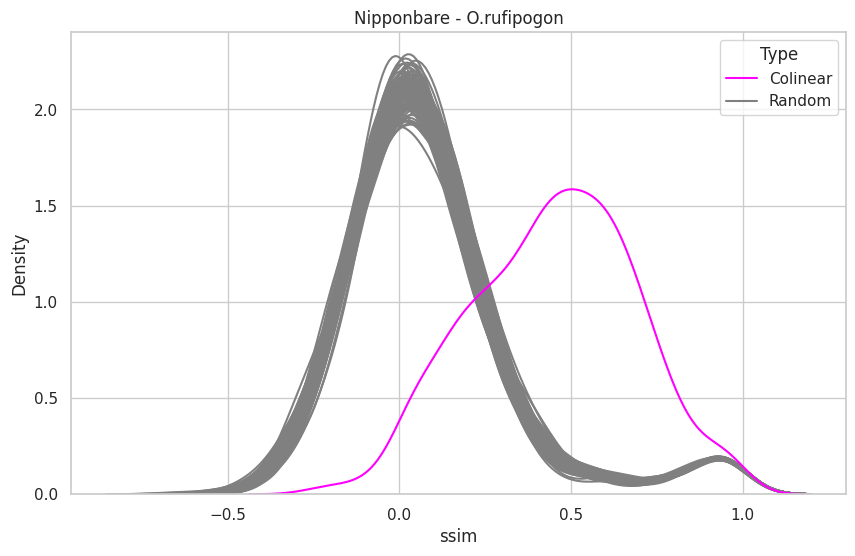

Total number of ssim values: 974
Number of rows with SN >= 0.5': 597
Mode of the density plot: 0.50
Average Mode of the density plots for random pairs': 0.025691282685695503
Normalized mode of the SSIM values: 0.4743087173143045


In [4]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_folder_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions_NPB_ref/NPB-Oruf/random_results_25'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'NPB-Oruf_chess_results_25kb.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# def custom_filter(row):
#     if row['type'] == 'experiment':
#         return row['p_bg'] <= 0.05
#     return True

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()

final_df_filtered['plot_order'] = final_df_filtered['type'].apply(lambda x: 0 if x == 'experiment' else 1)
final_df_filtered = final_df_filtered.sort_values(by='plot_order')

palette = {key: 'magenta' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)
handles, labels = plot.get_legend_handles_labels()

custom_handles = [plt.Line2D([0], [0], color='magenta'), plt.Line2D([0], [0], color='gray')]
custom_labels = ['Colinear', 'Random']

plt.legend(custom_handles, custom_labels, title='Type')

plt.xlabel('ssim')
plt.ylabel('Density')
plt.title('Nipponbare - O.rufipogon')

# Save the plot to a new PNG file with higher resolution (300 dpi)
plt.savefig('/scratch/ak8725/figs/fig6/fig6A-3.pdf')


plt.show()

# Count rows with type 'experiment'
rows_count = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", rows_count)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5':", experiment_rows_count)

#calculate mode of experiment
import numpy as np
import scipy.stats as stats

random_modes = []
experiment_mode = None

for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value
formatted_mode = f"{experiment_mode:.2f}"

# Print the mode for 'experiment'
print(f"Mode of the density plot: {formatted_mode}")
# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for random pairs': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

formatted_mode_numeric = float(formatted_mode)  # Convert to float if it's a string
result = formatted_mode_numeric - average_random_mode
print(f'Normalized mode of the SSIM values: {result}')

### Nipponbare - Omer

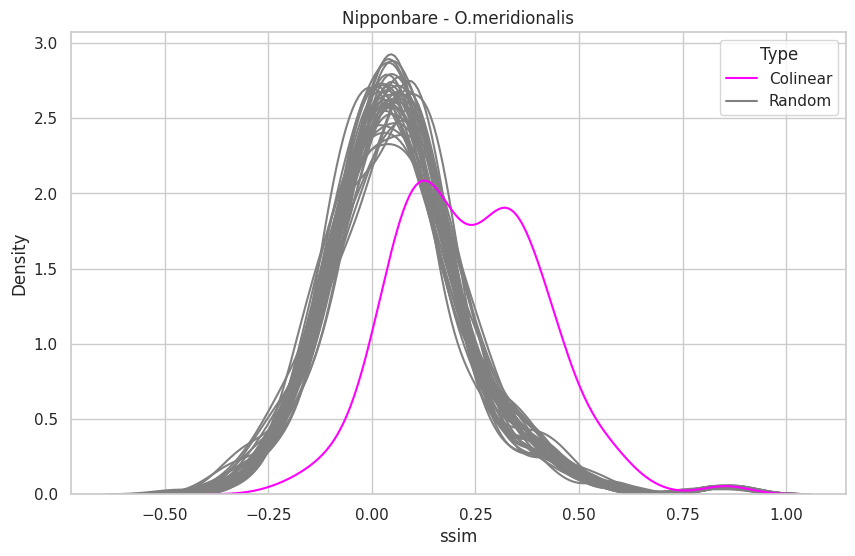

Total number of ssim values: 349
Number of rows with SN >= 0.5': 253
Mode of the density plot: 0.13
Average Mode of the density plots for random pairs': 0.048758216892592555
Normalized mode of the SSIM values: 0.08124178310740746


In [5]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_folder_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions_NPB_ref/NPB-Omer/random_results_25'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'NPB-Omer_chess_results_25kb.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# def custom_filter(row):
#     if row['type'] == 'experiment':
#         return row['p_bg'] <= 0.05
#     return True

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()

final_df_filtered['plot_order'] = final_df_filtered['type'].apply(lambda x: 0 if x == 'experiment' else 1)
final_df_filtered = final_df_filtered.sort_values(by='plot_order')

palette = {key: 'magenta' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)
handles, labels = plot.get_legend_handles_labels()

custom_handles = [plt.Line2D([0], [0], color='magenta'), plt.Line2D([0], [0], color='gray')]
custom_labels = ['Colinear', 'Random']

plt.legend(custom_handles, custom_labels, title='Type')

plt.xlabel('ssim')
plt.ylabel('Density')
plt.title('Nipponbare - O.meridionalis')

# Save the plot to a new PNG file with higher resolution (300 dpi)
plt.savefig('/scratch/ak8725/figs/fig6/fig6A-4.pdf')

plt.show()

# Count rows with type 'experiment'
rows_count = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", rows_count)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5':", experiment_rows_count)

#calculate mode of experiment
import numpy as np
import scipy.stats as stats

random_modes = []
experiment_mode = None

for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value
formatted_mode = f"{experiment_mode:.2f}"

# Print the mode for 'experiment'
print(f"Mode of the density plot: {formatted_mode}")
# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for random pairs': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

formatted_mode_numeric = float(formatted_mode)  # Convert to float if it's a string
result = formatted_mode_numeric - average_random_mode
print(f'Normalized mode of the SSIM values: {result}')

### Azucena - IR64

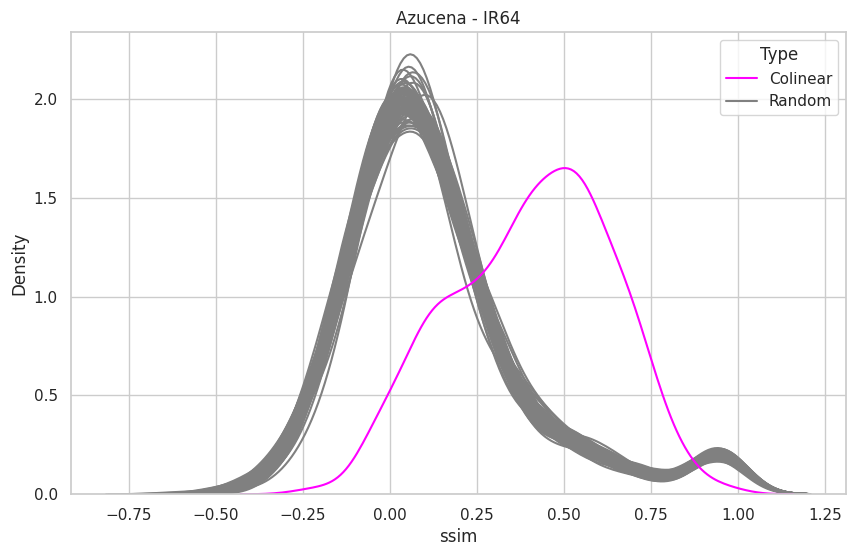

Total number of ssim values: 1044
Number of rows with SN >= 0.5': 868
Mode of the density plot: 0.50
Average Mode of the density plots for random pairs': 0.04740320869518552
Normalized mode of the SSIM values: 0.45259679130481445


In [6]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_folder_path = '/scratch/ak8725/chess/whole_lifted/az-ir64/random_results'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'az-ir64.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# def custom_filter(row):
#     if row['type'] == 'experiment':
#         return row['p_bg'] <= 0.05
#     return True

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()

final_df_filtered['plot_order'] = final_df_filtered['type'].apply(lambda x: 0 if x == 'experiment' else 1)
final_df_filtered = final_df_filtered.sort_values(by='plot_order')

palette = {key: 'magenta' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)
handles, labels = plot.get_legend_handles_labels()

custom_handles = [plt.Line2D([0], [0], color='magenta'), plt.Line2D([0], [0], color='gray')]
custom_labels = ['Colinear', 'Random']

plt.legend(custom_handles, custom_labels, title='Type')

plt.xlabel('ssim')
plt.ylabel('Density')
plt.title('Azucena - IR64')

# Save the plot to a new PNG file with higher resolution (300 dpi)
plt.savefig('/scratch/ak8725/figs/fig6/fig6A-5.pdf')


plt.show()

# Count rows with type 'experiment'
rows_count = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", rows_count)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5':", experiment_rows_count)

#calculate mode of experiment
import numpy as np
import scipy.stats as stats

random_modes = []
experiment_mode = None

for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value
formatted_mode = f"{experiment_mode:.2f}"

# Print the mode for 'experiment'
print(f"Mode of the density plot: {formatted_mode}")
# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for random pairs': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

formatted_mode_numeric = float(formatted_mode)  # Convert to float if it's a string
result = formatted_mode_numeric - average_random_mode
print(f'Normalized mode of the SSIM values: {result}')

### Azucena - Oruf

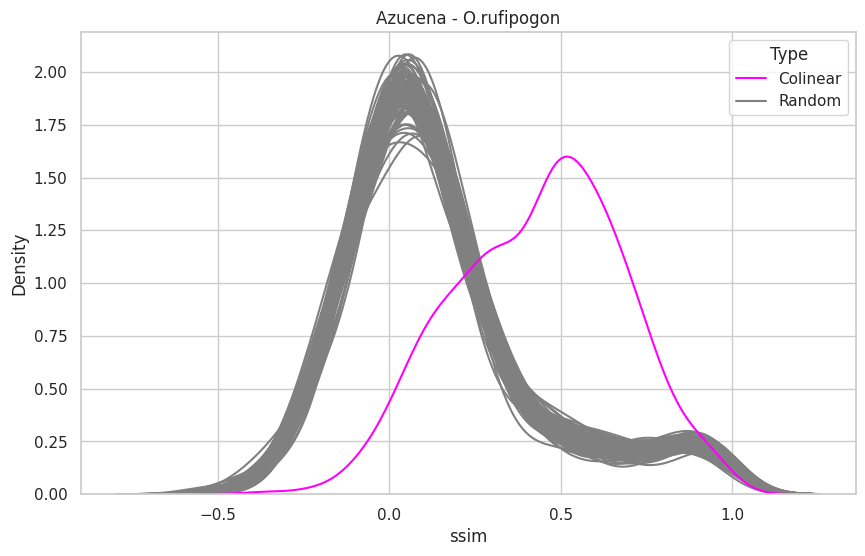

Total number of ssim values: 927
Number of rows with SN >= 0.5': 589
Mode of the density plot: 0.52
Average Mode of the density plots for random pairs': 0.04695279472657308
Normalized mode of the SSIM values: 0.4730472052734269


In [7]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_folder_path = '/scratch/ak8725/chess/whole_lifted/az-oruf/random_results'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'az-oruf.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# def custom_filter(row):
#     if row['type'] == 'experiment':
#         return row['p_bg'] <= 0.05
#     return True

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()

final_df_filtered['plot_order'] = final_df_filtered['type'].apply(lambda x: 0 if x == 'experiment' else 1)
final_df_filtered = final_df_filtered.sort_values(by='plot_order')

palette = {key: 'magenta' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)
handles, labels = plot.get_legend_handles_labels()

custom_handles = [plt.Line2D([0], [0], color='magenta'), plt.Line2D([0], [0], color='gray')]
custom_labels = ['Colinear', 'Random']

plt.legend(custom_handles, custom_labels, title='Type')

plt.xlabel('ssim')
plt.ylabel('Density')
plt.title('Azucena - O.rufipogon')

# Save the plot to a new PNG file with higher resolution (300 dpi)
plt.savefig('/scratch/ak8725/figs/fig6/fig6A-6.pdf')


plt.show()

# Count rows with type 'experiment'
rows_count = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", rows_count)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5':", experiment_rows_count)

#calculate mode of experiment
import numpy as np
import scipy.stats as stats

random_modes = []
experiment_mode = None

for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value
formatted_mode = f"{experiment_mode:.2f}"

# Print the mode for 'experiment'
print(f"Mode of the density plot: {formatted_mode}")
# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for random pairs': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

formatted_mode_numeric = float(formatted_mode)  # Convert to float if it's a string
result = formatted_mode_numeric - average_random_mode
print(f'Normalized mode of the SSIM values: {result}')

### Azucena - Omer

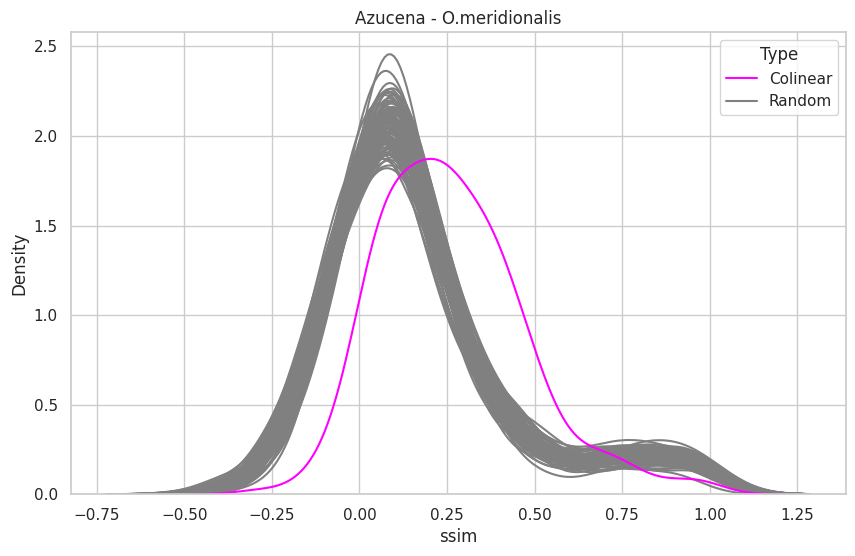

Total number of ssim values: 357
Number of rows with SN >= 0.5': 265
Mode of the density plot: 0.20
Average Mode of the density plots for random pairs': 0.08058907792000886
Normalized mode of the SSIM values: 0.11941092207999116


In [8]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_folder_path = '/scratch/ak8725/chess/whole_lifted/az-omer/random_results'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'az-omer.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# def custom_filter(row):
#     if row['type'] == 'experiment':
#         return row['p_bg'] <= 0.05
#     return True

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()

final_df_filtered['plot_order'] = final_df_filtered['type'].apply(lambda x: 0 if x == 'experiment' else 1)
final_df_filtered = final_df_filtered.sort_values(by='plot_order')

palette = {key: 'magenta' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)
handles, labels = plot.get_legend_handles_labels()

custom_handles = [plt.Line2D([0], [0], color='magenta'), plt.Line2D([0], [0], color='gray')]
custom_labels = ['Colinear', 'Random']

plt.legend(custom_handles, custom_labels, title='Type')

plt.xlabel('ssim')
plt.ylabel('Density')
plt.title('Azucena - O.meridionalis')

# Save the plot to a new PNG file with higher resolution (300 dpi)
plt.savefig('/scratch/ak8725/figs/fig6/fig6A-7.pdf')


plt.show()

# Count rows with type 'experiment'
rows_count = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", rows_count)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5':", experiment_rows_count)

#calculate mode of experiment
import numpy as np
import scipy.stats as stats

random_modes = []
experiment_mode = None

for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value
formatted_mode = f"{experiment_mode:.2f}"

# Print the mode for 'experiment'
print(f"Mode of the density plot: {formatted_mode}")
# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for random pairs': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

formatted_mode_numeric = float(formatted_mode)  # Convert to float if it's a string
result = formatted_mode_numeric - average_random_mode
print(f'Normalized mode of the SSIM values: {result}')

### IR64 - Oruf

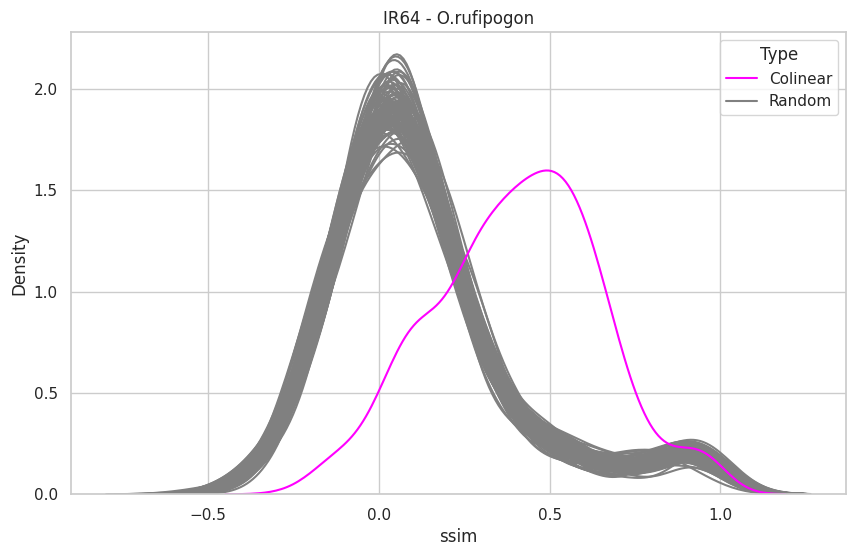

Total number of ssim values: 863
Number of rows with SN >= 0.5': 504
Mode of the density plot: 0.49
Average Mode of the density plots for random pairs': 0.03923835812793575
Normalized mode of the SSIM values: 0.45076164187206424


In [9]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_folder_path = '/scratch/ak8725/chess/whole_lifted/ir64-oruf/random_results'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'ir64-oruf.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# def custom_filter(row):
#     if row['type'] == 'experiment':
#         return row['p_bg'] <= 0.05
#     return True

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()

final_df_filtered['plot_order'] = final_df_filtered['type'].apply(lambda x: 0 if x == 'experiment' else 1)
final_df_filtered = final_df_filtered.sort_values(by='plot_order')

palette = {key: 'magenta' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)
handles, labels = plot.get_legend_handles_labels()

custom_handles = [plt.Line2D([0], [0], color='magenta'), plt.Line2D([0], [0], color='gray')]
custom_labels = ['Colinear', 'Random']

plt.legend(custom_handles, custom_labels, title='Type')

plt.xlabel('ssim')
plt.ylabel('Density')
plt.title('IR64 - O.rufipogon')

# Save the plot to a new PNG file with higher resolution (300 dpi)
plt.savefig('/scratch/ak8725/figs/fig6/fig6A-8.pdf')


plt.show()

# Count rows with type 'experiment'
rows_count = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", rows_count)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5':", experiment_rows_count)

#calculate mode of experiment
import numpy as np
import scipy.stats as stats

random_modes = []
experiment_mode = None

for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value
formatted_mode = f"{experiment_mode:.2f}"

# Print the mode for 'experiment'
print(f"Mode of the density plot: {formatted_mode}")
# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for random pairs': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

formatted_mode_numeric = float(formatted_mode)  # Convert to float if it's a string
result = formatted_mode_numeric - average_random_mode
print(f'Normalized mode of the SSIM values: {result}')

### IR64 - Omer

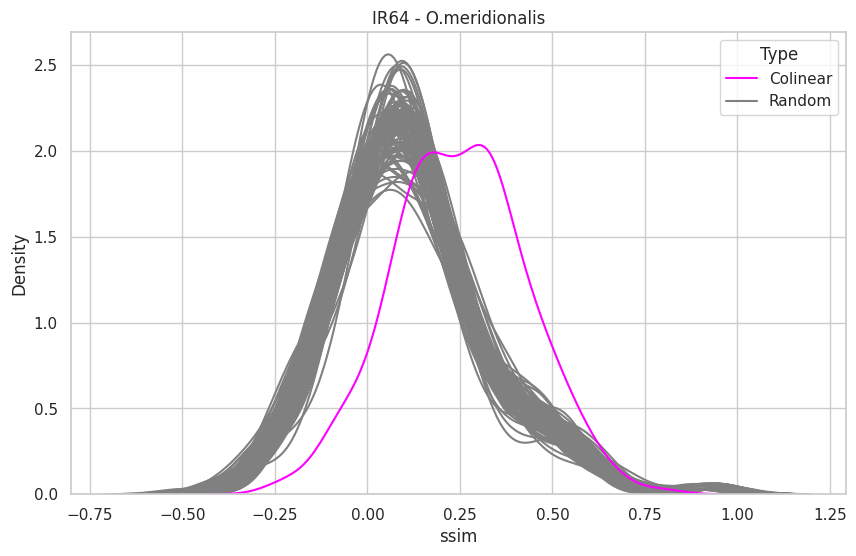

Total number of ssim values: 377
Number of rows with SN >= 0.5': 255
Mode of the density plot: 0.30
Average Mode of the density plots for random pairs': 0.07765068277358587
Normalized mode of the SSIM values: 0.2223493172264141


In [10]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_folder_path = '/scratch/ak8725/chess/whole_lifted/ir64-omer/random_results'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'ir64-omer.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# def custom_filter(row):
#     if row['type'] == 'experiment':
#         return row['p_bg'] <= 0.05
#     return True

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()

final_df_filtered['plot_order'] = final_df_filtered['type'].apply(lambda x: 0 if x == 'experiment' else 1)
final_df_filtered = final_df_filtered.sort_values(by='plot_order')

palette = {key: 'magenta' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)
handles, labels = plot.get_legend_handles_labels()

custom_handles = [plt.Line2D([0], [0], color='magenta'), plt.Line2D([0], [0], color='gray')]
custom_labels = ['Colinear', 'Random']

plt.legend(custom_handles, custom_labels, title='Type')

plt.xlabel('ssim')
plt.ylabel('Density')
plt.title('IR64 - O.meridionalis')

# Save the plot to a new PNG file with higher resolution (300 dpi)
plt.savefig('/scratch/ak8725/figs/fig6/fig6A-9.pdf')


plt.show()

# Count rows with type 'experiment'
rows_count = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", rows_count)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5':", experiment_rows_count)

#calculate mode of experiment
import numpy as np
import scipy.stats as stats

random_modes = []
experiment_mode = None

for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value
formatted_mode = f"{experiment_mode:.2f}"

# Print the mode for 'experiment'
print(f"Mode of the density plot: {formatted_mode}")
# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for random pairs': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

formatted_mode_numeric = float(formatted_mode)  # Convert to float if it's a string
result = formatted_mode_numeric - average_random_mode
print(f'Normalized mode of the SSIM values: {result}')

### Oruf - Omer

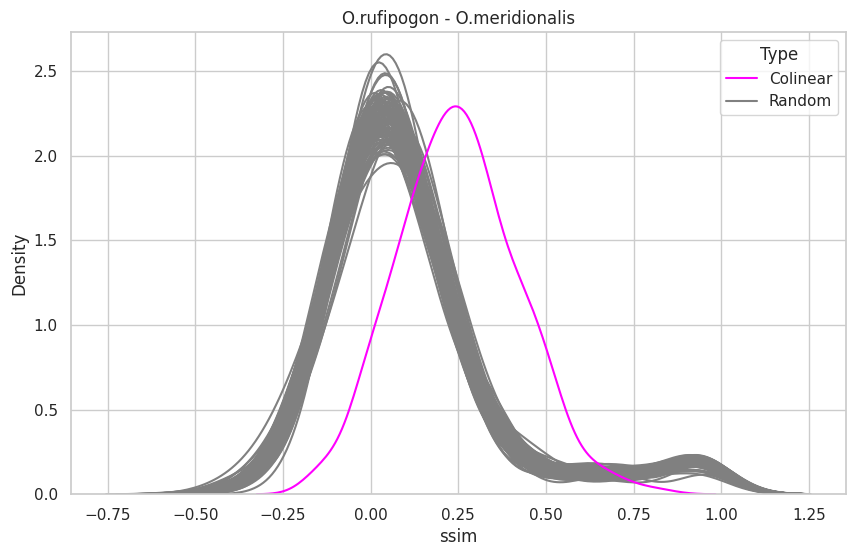

Total number of ssim values: 346
Number of rows with SN >= 0.5': 297
Mode of the density plot: 0.24
Average Mode of the density plots for random pairs': 0.03897198210962539
Normalized mode of the SSIM values: 0.2010280178903746
Average Mode of the density plots for random pairs': 0.03897198210962539
Normalized mode of the SSIM values: 0.2010280178903746


In [11]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_folder_path = '/scratch/ak8725/chess/whole_lifted/oruf-omer/random_results'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'oruf-omer.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# def custom_filter(row):
#     if row['type'] == 'experiment':
#         return row['p_bg'] <= 0.05
#     return True

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()

final_df_filtered['plot_order'] = final_df_filtered['type'].apply(lambda x: 0 if x == 'experiment' else 1)
final_df_filtered = final_df_filtered.sort_values(by='plot_order')

palette = {key: 'magenta' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)
handles, labels = plot.get_legend_handles_labels()

custom_handles = [plt.Line2D([0], [0], color='magenta'), plt.Line2D([0], [0], color='gray')]
custom_labels = ['Colinear', 'Random']

plt.legend(custom_handles, custom_labels, title='Type')

plt.xlabel('ssim')
plt.ylabel('Density')
plt.title('O.rufipogon - O.meridionalis')

# Save the plot to a new PNG file with higher resolution (300 dpi)
plt.savefig('/scratch/ak8725/figs/fig6/fig6A-10.pdf')


plt.show()

# Count rows with type 'experiment'
rows_count = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", rows_count)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5':", experiment_rows_count)

#calculate mode of experiment
import numpy as np
import scipy.stats as stats

random_modes = []
experiment_mode = None

for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value
formatted_mode = f"{experiment_mode:.2f}"

# Print the mode for 'experiment'
print(f"Mode of the density plot: {formatted_mode}")
# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for random pairs': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

formatted_mode_numeric = float(formatted_mode)  # Convert to float if it's a string
result = formatted_mode_numeric - average_random_mode
print(f'Normalized mode of the SSIM values: {result}')
# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for random pairs': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

formatted_mode_numeric = float(formatted_mode)  # Convert to float if it's a string
result = formatted_mode_numeric - average_random_mode
print(f'Normalized mode of the SSIM values: {result}')

## Combining the experimental plots

In [18]:
from PIL import Image

# List of paths to your 10 PNG files
image_paths = [
    'npb-az.png',
    'npb-ir64.png',
    'npb-oruf.png',
    'npb-omer.png',
    'az-ir64.png',
    'az-oruf.png',
    'az-omer.png',
    'ir64-oruf.png',
    'ir64-omer.png',
    'oruf-omer.png',
]

# Specify the order of images (0-indexed)
image_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Define the layout (3 rows, 4 columns)
rows, cols = 3, 4

# Calculate the size of the combined image
combined_width = sum(Image.open(image_paths[i]).width for i in image_order[:cols])
combined_height = Image.open(image_paths[0]).height * rows

# Create a blank image with a white background
combined_image = Image.new('RGB', (combined_width, combined_height), 'white')

# Paste the images into the combined image
for i, image_index in enumerate(image_order):
    col_index = i % cols
    row_index = i // cols

    # Calculate the position to paste the current image
    paste_x = col_index * Image.open(image_paths[i]).width
    paste_y = row_index * Image.open(image_paths[i]).height

    # Open the current image
    current_image = Image.open(image_paths[image_index])

    # Paste the current image into the combined image
    combined_image.paste(current_image, (paste_x, paste_y))

# Save the combined image
combined_image.save('fig6A.pdf')

## Combining the biological replicates' plots

In [15]:
from PIL import Image

# List of paths to your 10 PNG files
image_paths = [
    'npb_rep.png',
    'az_rep.png',
    'ir64_rep.png',
    'oruf_rep.png',
    'omer_rep.png'
]

# Specify the order of images (0-indexed)
image_order = [0, 1, 2, 3, 4]

# Define the layout (3 rows, 4 columns)
rows, cols = 2, 3

# Calculate the size of the combined image
combined_width = sum(Image.open(image_paths[i]).width for i in image_order[:cols])
combined_height = Image.open(image_paths[0]).height * rows

# Create a blank image with a white background
combined_image = Image.new('RGB', (combined_width, combined_height), 'white')

# Paste the images into the combined image
for i, image_index in enumerate(image_order):
    col_index = i % cols
    row_index = i // cols

    # Calculate the position to paste the current image
    paste_x = col_index * Image.open(image_paths[i]).width
    paste_y = row_index * Image.open(image_paths[i]).height

    # Open the current image
    current_image = Image.open(image_paths[image_index])

    # Paste the current image into the combined image
    combined_image.paste(current_image, (paste_x, paste_y))

# Save the combined image
combined_image.save('/scratch/ak8725/figs/figS1.pdf')

## Hierarchical clustering of samples based on pairwise modes of density plots

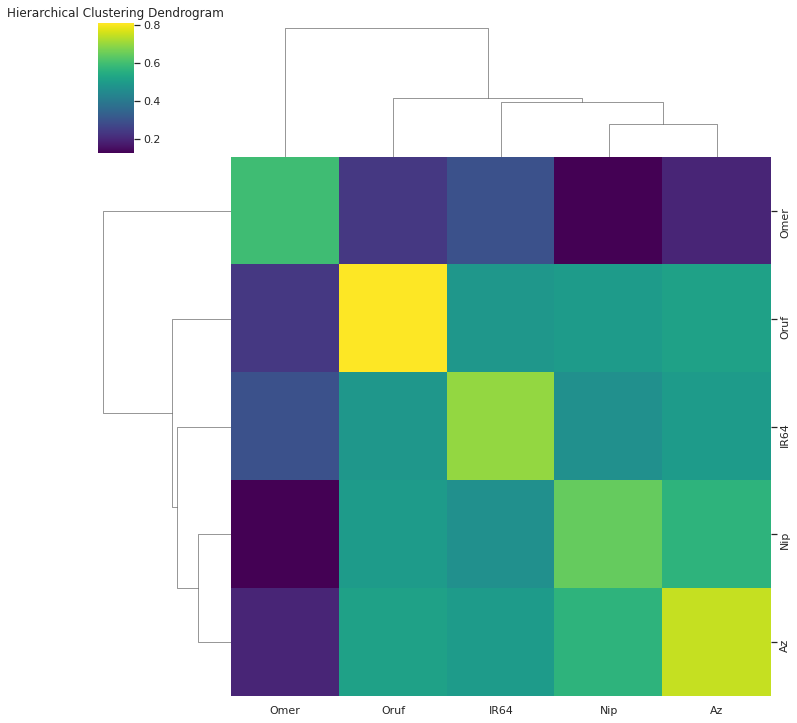

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Your sample names
sample_names = ['Nip', 'Az', 'IR64', 'Oruf', 'Omer']

# Manually specify pairs and corresponding scores
data = {'Nip': {'Nip': 0.65, 'Az': 0.57, 'IR64': 0.47, 'Oruf': 0.5, 'Omer': 0.13},
        'Az': {'Nip': 0.57, 'Az': 0.75, 'IR64': 0.5, 'Oruf': 0.52, 'Omer': 0.2},
        'IR64': {'Nip': 0.47, 'Az': 0.5, 'IR64': 0.7, 'Oruf': 0.49, 'Omer': 0.3},
        'Oruf': {'Nip': 0.5, 'Az': 0.52, 'IR64': 0.49, 'Oruf': 0.81, 'Omer': 0.24},
        'Omer': {'Nip': 0.13, 'Az': 0.2, 'IR64': 0.3, 'Oruf': 0.24, 'Omer': 0.6}}

# Create a DataFrame
df = pd.DataFrame(data)

# Create a clustered heatmap
sns.clustermap(df, method='average', cmap='viridis',
               xticklabels=sample_names, yticklabels=sample_names)

# Show the plot
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

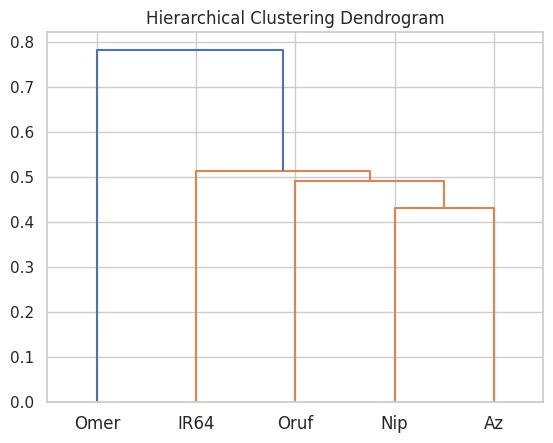

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram

# Your sample names
sample_names = ['Nip', 'Az', 'IR64', 'Oruf', 'Omer']

# Manually specify pairs and corresponding scores
data = {'Nip': {'Nip': 0.65, 'Az': 0.57, 'IR64': 0.47, 'Oruf': 0.5, 'Omer': 0.13},
        'Az': {'Nip': 0.57, 'Az': 0.75, 'IR64': 0.5, 'Oruf': 0.52, 'Omer': 0.2},
        'IR64': {'Nip': 0.47, 'Az': 0.5, 'IR64': 0.69, 'Oruf': 0.49, 'Omer': 0.3},
        'Oruf': {'Nip': 0.5, 'Az': 0.52, 'IR64': 0.49, 'Oruf': 1, 'Omer': 0.24},
        'Omer': {'Nip': 0.13, 'Az': 0.2, 'IR64': 0.3, 'Oruf': 0.24, 'Omer': 0.54}}

# Create a DataFrame
df = pd.DataFrame(data)

# Convert similarity values to distances
distance_matrix = 1 - df

# Ensure the diagonal elements are set to zero
for i in range(len(sample_names)):
    distance_matrix.iloc[i, i] = 0

# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(squareform(distance_matrix), method='average')

# Create a dendrogram
dendrogram(linkage_matrix, labels=sample_names)

# Show the plot
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

# NJ tree from SSIM values

In [22]:
# Manually specify pairs and corresponding scores
data = {'Nip': {'Nip': 0.65, 'Az': 0.57, 'IR64': 0.47, 'Oruf': 0.5, 'Omer': 0.13},
        'Az': {'Nip': 0.57, 'Az': 0.75, 'IR64': 0.5, 'Oruf': 0.52, 'Omer': 0.2},
        'IR64': {'Nip': 0.47, 'Az': 0.5, 'IR64': 0.69, 'Oruf': 0.49, 'Omer': 0.3},
        'Oruf': {'Nip': 0.5, 'Az': 0.52, 'IR64': 0.49, 'Oruf': 1, 'Omer': 0.24},
        'Omer': {'Nip': 0.13, 'Az': 0.2, 'IR64': 0.3, 'Oruf': 0.24, 'Omer': 0.54}}

# Create a DataFrame
df = pd.DataFrame(data)

# Convert similarity values to distances
distance_matrix = 1 - df

# Ensure the diagonal elements are set to zero
for i in range(len(sample_names)):
    distance_matrix.iloc[i, i] = 0
print(distance_matrix)

       Nip    Az  IR64  Oruf  Omer
Nip   0.00  0.43  0.53  0.50  0.87
Az    0.43  0.00  0.50  0.48  0.80
IR64  0.53  0.50  0.00  0.51  0.70
Oruf  0.50  0.48  0.51  0.00  0.76
Omer  0.87  0.80  0.70  0.76  0.00


In [23]:
from Bio.Phylo.TreeConstruction import DistanceMatrix

# Corrected lower triangular matrix
lower_triangular_matrix = [[0],
                          [0.43, 0],
                          [0.53, 0.5, 0],
                          [0.5, 0.48, 0.51, 0],
                          [0.87, 0.8, 0.7, 0.76, 0]]
        
# Labels for the rows/columns
labels = ['Nip', 'Az', 'IR64', 'Oruf', 'Omer']

# Create DistanceMatrix object
distance_matrix = DistanceMatrix(labels, lower_triangular_matrix)

# Display the distance matrix
print(distance_matrix)

Nip 0.000000
Az  0.430000    0.000000
IR64    0.530000    0.500000    0.000000
Oruf    0.500000    0.480000    0.510000    0.000000
Omer    0.870000    0.800000    0.700000    0.760000    0.000000
    Nip Az  IR64    Oruf    Omer


In [24]:
# Construct the phlyogenetic tree using NJ algorithm
NJTree = constructor.nj(distance_matrix)
# Draw the phlyogenetic tree using terminal
Phylo.draw_ascii(NJTree)

  __________________________ Nip
 |
_|______________________ Az
 |
 |     __________________________ Oruf
 |____|
      |        __________________________________________________________ Omer
      |_______|
              |______________________ IR64



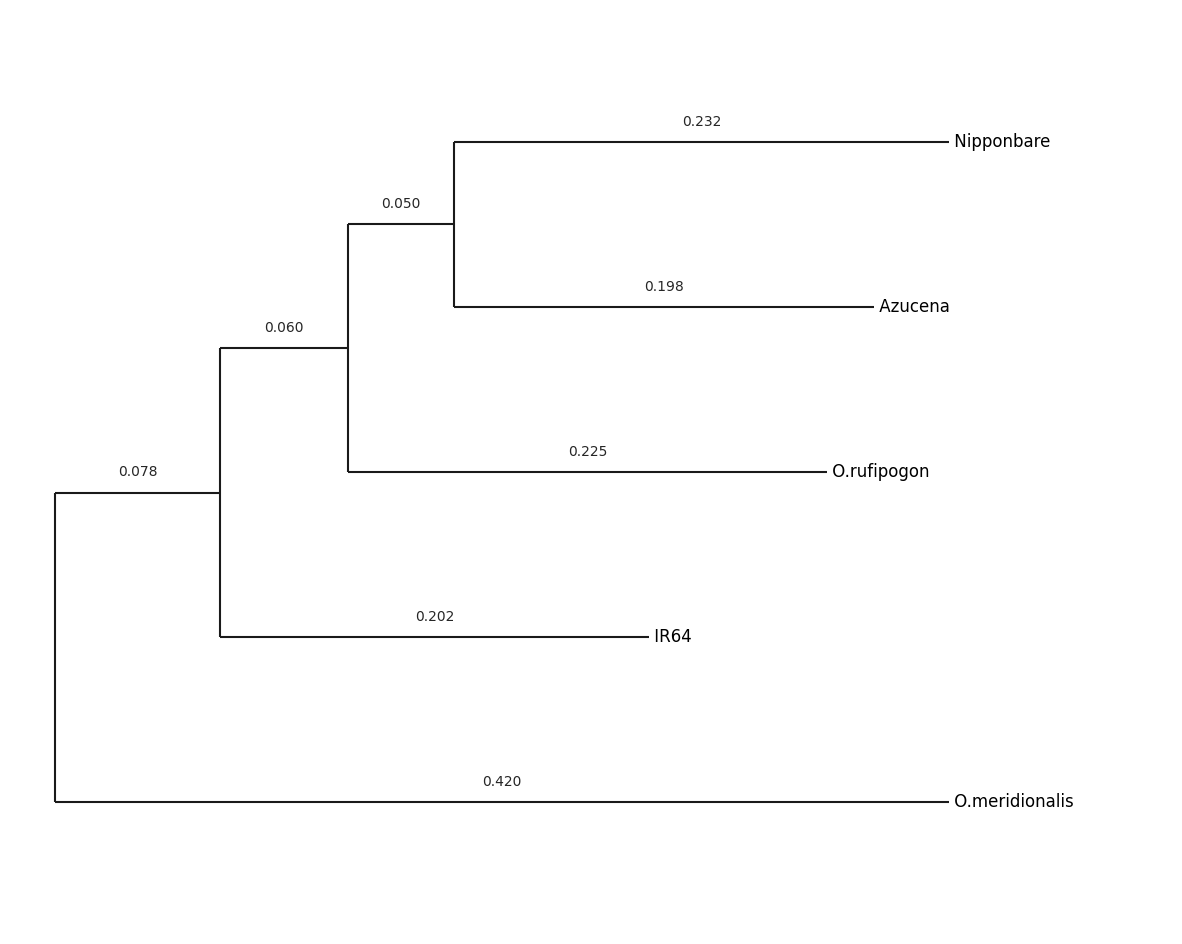

In [26]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix
from Bio import Phylo
import matplotlib.pyplot as plt

# Labels for the rows/columns
labels = ['Nipponbare', 'Azucena', 'IR64', 'O.rufipogon', 'O.meridionalis']

# Create DistanceMatrix object from the original data
original_distance_matrix = DistanceMatrix(labels, lower_triangular_matrix)

# Use the DistanceTreeConstructor to build a tree
constructor = DistanceTreeConstructor()
NJTree = constructor.nj(original_distance_matrix)

# Root the NJ tree at the calculated midpoint
NJTree.root_at_midpoint()

# Display the rooted NJ tree with customizations
fig, ax = plt.subplots(figsize=(15, 12))  # Set the figure size
ax.set_frame_on(False)  # Turn off the frame
ax.xaxis.set_visible(False)  # Turn off the x-axis
ax.yaxis.set_visible(False)  # Turn off the y-axis

# Customize the appearance of the tree
for clade in NJTree.find_clades(order='postorder'):
    clade.width = 1.0  # Set branch width
    if clade.branch_length is not None and clade.branch_length != 0.0:  # Check if branch length is not None or 0.00
        label = f"{clade.branch_length:.2f}\n"  # Add a line break after the value

# Plot the tree
Phylo.draw(NJTree, axes=ax,
           branch_labels=lambda c: f"{c.branch_length:.3f}\n" if c.branch_length != 0.0 else '',  # Add a line break after the value if not 0.00
           label_func=lambda x: x.name if x.is_terminal() else None)

# Save the tree as a PNG with dpi = 300
fig.patch.set_facecolor('white')
fig.savefig("/scratch/ak8725/figs/figS2B.pdf", bbox_inches='tight')
plt.close(fig)

### (optional) Calculating the modes of the experimental ssim values and average of random values modes

In [43]:
import numpy as np
import scipy.stats as stats
import pandas as pd

# Assuming 'final_df_filtered' is your DataFrame

# Create a list to collect mode values for random_{index}
random_modes = []

# Variables to store mode for 'experiment'
experiment_mode = None

# Find mode for each density plot
for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['z_ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value

# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for 'random_{{index}}': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

# Print the mode for 'experiment'
if experiment_mode is not None:
    print(f"Mode of the density plot for 'experiment': {experiment_mode}")
else:
    print("No valid data found for 'experiment'")

Average Mode of the density plots for 'random_{index}': -0.13651724507759616
Mode of the density plot for 'experiment': 0.32424412636901545


### (not in paper) Calculating the median of the experimental ssim values

In [16]:
import numpy as np

# Create subsets based on different types
subset_25kb = final_df_filtered[final_df_filtered['type'] == 'experiment']

# Calculate the medians for each subset, ignoring NaN values
median_25kb = np.nanmedian(subset_25kb['z_ssim'])

print("Median of the distribution for 25kb:", median_25kb)

Median of the distribution for 25kb: 0.1264050343635555


# NJ tree from median dS values

In [2]:
# Manually specify pairs and corresponding scores
data = {'Nip': {'Nip': 0., 'Az': 0., 'IR64': 0.00613, 'Oruf': 0.003444, 'Omer': 0.04083},
        'Az': {'Nip': 0., 'Az': 0., 'IR64': 0.0038655, 'Oruf': 0.0045595, 'Omer': 0.04174},
        'IR64': {'Nip': 0.00613, 'Az': 0.0038655, 'IR64': 0., 'Oruf': 0.008038, 'Omer': 0.04236},
        'Oruf': {'Nip': 0.003444, 'Az': 0.0045595, 'IR64': 0.008038, 'Oruf': 0, 'Omer': 0.04211},
        'Omer': {'Nip': 0.04083, 'Az': 0.04174, 'IR64': 0.04236, 'Oruf': 0.04211, 'Omer': 0.}}

# Create a DataFrame
df = pd.DataFrame(data)

# Convert similarity values to distances
distance_matrix = df

# Ensure the diagonal elements are set to zero
for i in range(len(sample_names)):
    distance_matrix.iloc[i, i] = 0
print(distance_matrix)

           Nip        Az      IR64      Oruf     Omer
Nip   0.000000  0.000000  0.006130  0.003444  0.04083
Az    0.000000  0.000000  0.003866  0.004560  0.04174
IR64  0.006130  0.003866  0.000000  0.008038  0.04236
Oruf  0.003444  0.004560  0.008038  0.000000  0.04211
Omer  0.040830  0.041740  0.042360  0.042110  0.00000


In [2]:
from Bio.Phylo.TreeConstruction import DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo

# Corrected lower triangular matrix
lower_triangular_matrix = [[0],
                          [0, 0],
                          [0.006130, 0.003866, 0],
                          [0.003444, 0.004560, 0.008038, 0],
                          [0.040830, 0.041740, 0.042360, 0.042110, 0]]
        
# Labels for the rows/columns
labels = ['Nip', 'Az', 'IR64', 'Oruf', 'Omer']

# Create DistanceMatrix object
distance_matrix = DistanceMatrix(labels, lower_triangular_matrix)

# Display the distance matrix
print(distance_matrix)

Nip 0.000000
Az  0.000000    0.000000
IR64    0.006130    0.003866    0.000000
Oruf    0.003444    0.004560    0.008038    0.000000
Omer    0.040830    0.041740    0.042360    0.042110    0.000000
    Nip Az  IR64    Oruf    Omer


In [3]:
# Construct the phlyogenetic tree using NJ algorithm
NJTree = constructor.nj(distance_matrix)
# Draw the phlyogenetic tree using terminal
Phylo.draw_ascii(NJTree)

NameError: name 'constructor' is not defined

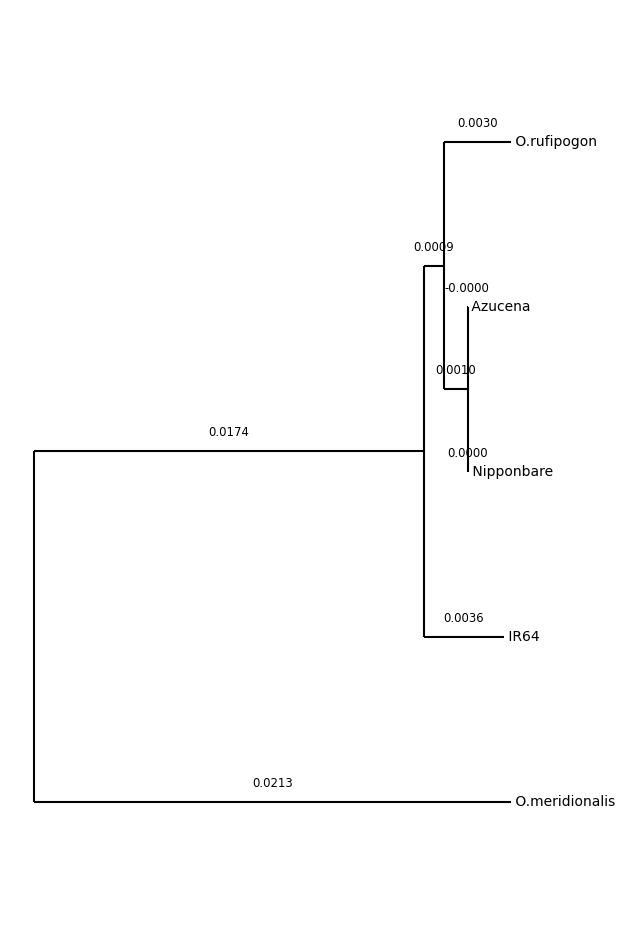

In [5]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix
from Bio import Phylo
import matplotlib.pyplot as plt

# Labels for the rows/columns
labels = ['Nipponbare', 'Azucena', 'IR64', 'O.rufipogon', 'O.meridionalis']

# Create DistanceMatrix object from the original data
original_distance_matrix = DistanceMatrix(labels, lower_triangular_matrix)

# Use the DistanceTreeConstructor to build a tree
constructor = DistanceTreeConstructor()
NJTree = constructor.nj(original_distance_matrix)

# Root the NJ tree at the calculated midpoint
NJTree.root_at_midpoint()

# Display the rooted NJ tree with customizations
fig, ax = plt.subplots(figsize=(8, 12))  # Set the figure size
ax.set_frame_on(False)  # Turn off the frame
ax.xaxis.set_visible(False)  # Turn off the x-axis
ax.yaxis.set_visible(False)  # Turn off the y-axis

# Customize the appearance of the tree
for clade in NJTree.find_clades(order='postorder'):
    clade.width = 1.0  # Set branch width
    if clade.branch_length is not None and clade.branch_length != 0.0:  # Check if branch length is not None or 0.00
        label = f"{clade.branch_length:.2f}\n"  # Add a line break after the value

# Plot the tree
Phylo.draw(NJTree, axes=ax,
           branch_labels=lambda c: f"{c.branch_length:.4f}\n" if c.branch_length != 0.0 else '',  # Add a line break after the value if not 0.00
           label_func=lambda x: x.name if x.is_terminal() else None)

# Save the tree as a PNG with dpi = 300
fig.patch.set_facecolor('white')
fig.savefig("/scratch/ak8725/figs/NJ_tree_dS.pdf", bbox_inches='tight')
plt.close(fig)